In [1]:
import sys
sys.path.append("../../src/")
from mfmodeling import SingleGP
help(SingleGP)

Help on class SingleGP in module mfmodeling.mfmodeling:

class SingleGP(builtins.object)
 |  SingleGP(*args, **kwargs)
 |  
 |  Gaussian process regression
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *args, **kwargs)
 |      Parameters
 |      ----------
 |      data : list[2]
 |          List of training data of y=f(x), where data input x and output y are vectors.
 |          [data_input[nsample,ninput], data_output[nsample,noutput]]
 |  
 |  optimize(self, optimize_restarts=30, max_iters=400, verbose=True)
 |      Parameters
 |      ----------
 |      optimize_restarts : Int
 |      max_iters : Int
 |      verbose : Bool
 |          Parameters in GPy.models.GPRegression.optimize_restarts()
 |  
 |  predict(self, x)
 |      Parameters
 |      ----------
 |      x : Numpy.ndarray[..., ninput]
 |          The points at which to make a prediction
 |      
 |      Returns
 |      -------
 |      mean : Numpy.ndarray[..., noutput]
 |      variance : Numpy.ndarray[..., noutput]
 

### Preparation of data set
https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import pandas as pd

co2 = fetch_openml(data_id=41187, as_frame=True)
co2.frame.head()
co2_data = co2.frame
co2_data["date"] = pd.to_datetime(co2_data[["year", "month", "day"]])
co2_data = co2_data[["date", "co2"]].set_index("date")
co2_data.head()
try:
    co2_data_resampled_monthly = co2_data.resample("ME")
except ValueError:
    # pandas < 2.2 uses M instead of ME
    co2_data_resampled_monthly = co2_data.resample("M")
co2_data = co2_data_resampled_monthly.mean().dropna(axis="index", how="any")
x = (co2_data.index.year + co2_data.index.month / 12).to_numpy().reshape(-1, 1)
y = co2_data["co2"].to_numpy()[:,np.newaxis]

(521, 1) (521, 1)


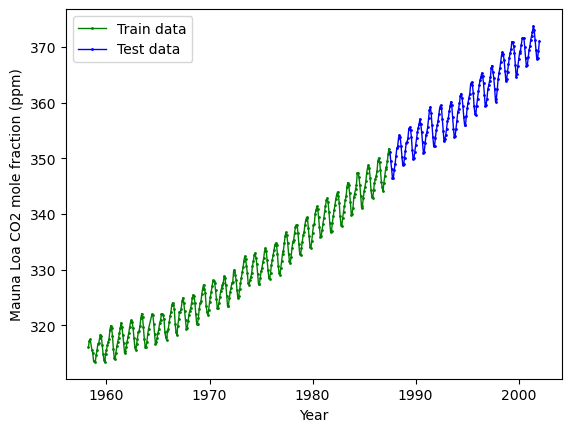

In [3]:
data_all = [x,y]
print(x.shape, y.shape)
nsplit = data_all[0].shape[0]//3*2
data_train = [x[:nsplit],y[:nsplit]]
data_test = [x[nsplit:],y[nsplit:]]

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(data_train[0], data_train[1], 'g.-', label='Train data', linewidth = 1, markersize=2)
ax.plot(data_test[0], data_test[1], 'b.-', label='Test data', linewidth = 1, markersize=2)
ax.set_xlabel("Year")
ax.set_ylabel("Mauna Loa CO2 mole fraction (ppm)")
ax.legend()
plt.show()

### Gaussian process regression

In [4]:
# Create Single GP instance with training data set
model_singleGP = SingleGP(data = data_train)
# Optimize hyper parameters
model_singleGP.optimize()

print(model_singleGP.model)

optimize_restarts= 30 , max_iters= 400


reconstraining parameters GP_regression.Gaussian_noise.variance
 /home/smae/.local/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/30, f = 748.4994622825225
Optimization restart 2/30, f = 748.482132026537
Optimization restart 3/30, f = 748.4821322391797
Optimization restart 4/30, f = 748.4821320890535
Optimization restart 5/30, f = 748.4821315517431
Optimization restart 6/30, f = 748.482265348443
Optimization restart 7/30, f = 748.4821318634633
Optimization restart 8/30, f = 748.4829747973757
Optimization restart 9/30, f = 748.4832556810557


 /home/smae/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in divide
 /home/smae/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/smae/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/smae/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide


Optimization restart 10/30, f = 761.3601948002142
Optimization restart 11/30, f = 748.4821395584412
Optimization restart 12/30, f = 748.4821318182396
Optimization restart 13/30, f = 748.4821321883298
Optimization restart 14/30, f = 749.2451092135607
Optimization restart 15/30, f = 748.4821322735966
Optimization restart 16/30, f = 748.4821320169192
Optimization restart 17/30, f = 762.7944424401055
Optimization restart 18/30, f = 748.4821325981713
Optimization restart 19/30, f = 748.4821317924714
Optimization restart 20/30, f = 748.482132226164
Optimization restart 21/30, f = 748.4821320234626
Optimization restart 22/30, f = 748.4843949474489
Optimization restart 23/30, f = 748.4904046049833
Optimization restart 24/30, f = 748.4821320583197
Optimization restart 25/30, f = 748.482132196309
Optimization restart 26/30, f = 749.4889570916049
Optimization restart 27/30, f = 748.4821320009007
Optimization restart 28/30, f = 748.4821331374433
Optimization restart 29/30, f = 748.4821318025868
Op

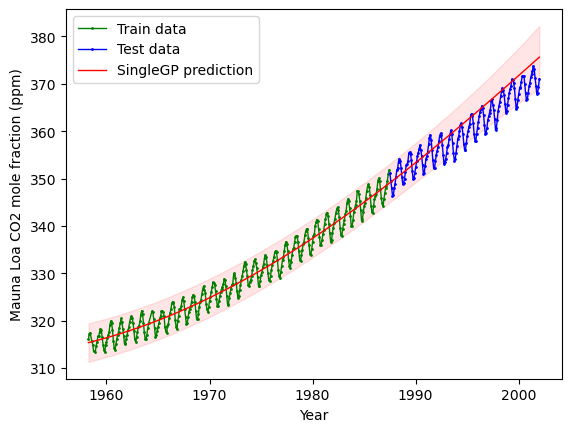

In [5]:
# Prediction
mean, var = model_singleGP.predict(x)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(data_train[0], data_train[1], 'g.-', label='Train data', linewidth = 1, markersize=2)
ax.plot(data_test[0], data_test[1], 'b.-', label='Test data', linewidth = 1, markersize=2)
ax.plot(x[:,0], mean[:,0], 'r', label = 'SingleGP prediction', linewidth = 1)
ax.fill_between(x[:,0], (mean[:,0]-2.0*np.sqrt(var[:,0])).ravel(), (mean[:,0]+2.0*np.sqrt(var[:,0])).ravel(), alpha=0.1, color='red')
ax.set_xlabel("Year")
ax.set_ylabel("Mauna Loa CO2 mole fraction (ppm)")
ax.legend()
plt.show()